In [114]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint
from scipy.optimize import brentq
from scipy.signal import argrelextrema
import random as rd
import math as math

In [130]:
t_f = 500
t_i = 0
dt = .1
tvector = np.arange(t_i, t_f, dt)
tmax = len(tvector)


def stepfct(S):# approximate the function maximum by a smooth function
    return .5+.5*np.tanh(100*S);
ome=1.
#KK= 0,
#K12= 430*ome
#kdT= 100*ome
#kdS=100*ome
#kdD=100*ome 

#parms = {'KK': 0,'K12': 430*ome,'kdT': 100*ome,'kdS': 100*ome,'kdD': 100*ome, 'k0UT': 0, 'k0TD': 0, 'k0US': 0, 'k0SD': 0,'k0DS': .31, 'k0DT': 0, 'k0TU': 0.21, \
#'k0SU': 0.11, 'kAUT': 0.4791, 'kATD': 0.2129,'kASD': 0.5,'kADS':-.3194,'kADT':  .173,'kATU':.0798,'kASU':-.1331,'V': 0.0078,'K1': 0.1,'Ks': 2.7,'Vd': 0.022,'Km':0.2,'Ki': 1, \
#'Vs':2,'Vm':0.2,'Ui': 2.23,'Si': 0.83,'Ti': 0.31,'Di': 0.48,'Mi': 0.037}

class monomer_clock:
	def __init__(self,params={}):
		self.k0UT=0
		self.k0TD=0
		self.k0US=0
		self.k0SD= 0     
		self.k0DS=.31
		self.k0DT=0
		self.k0TU=0.21
		self.k0SU= 0.11
        
		self.kAUT=0.4791
		self.kATD=0.2129
		self.kAUS=  0.0532 
		self.kASD= 0.5  #0.5057
		self.kADS=-.3194
		self.kADT=  .173
		self.kATU=.0798
		self.kASU=-.1331             

		self.ome = 1.0 # ome is there to be able to change the units if needed
		self.kaiA = 1.300*self.ome
		self.KK = 0 # (*original value 0*)
		self.KD = 0 # (*original value 0*)
		self.KT = 0
		self.K12 = .430*self.ome
		#kdU=100*ome
		self.kdT = .100*self.ome
		self.kdS = .100*self.ome
		self.kdD = .100*self.ome
        
		self.V = 0.0078
		self.K1= 0.1
		self.Ks = 2.7
		self.Vd = 0.022
		self.Km =0.2
		self.Ki = 1
		self.Vs = 2
		self.Vm =0.2
        #choose default initial conditons
		self.Ui = 2.23
		self.Si = 0.83
		self.Ti = 0.31
		self.Di = 0.48
		self.Mi = 0.037
		#choose an index to estimate period
		self.index_choice = 2
		return
    
	def aaa(self,S): # use in the eqs (see later)
		return (self.kaiA-2*S)*stepfct(self.kaiA-2*S)

	def kk(self,k0,kA,S):
		return k0+((kA*self.aaa(S))/(self.K12+self.aaa(S)))
	def kTU(self,S):
		return self.kk(self.k0TU,self.kATU,S)
	def kUT(self,S):
		return self.kk(self.k0UT,self.kAUT,S)
	def kSU(self,S):
		return self.kk(self.k0SU,self.kASU,S)
	def kUS(self,S):
		return self.kk(self.k0US,self.kAUS,S)
	def kDT(self,S):
		return self.kk(self.k0DT,self.kADT,S)
	def kTD(self,S):
		return self.kk(self.k0TD,self.kATD,S)
	def kDS(self,S):
		return self.kk(self.k0DS,self.kADS,S)
	def kSD(self,S):
		return self.kk(self.k0SD,self.kASD,S)


	def setparameters(self, params):
		"""The function setparameters assignes values to parameters of the model (the parameters encoded in the dictionary 'params') """ 
		self.V  = params['V']
		self.K1 = params['K1']
		self.Ks = params['Ks']
		self.Vd = params['Vd']
		self.Km = params['Km']
		self.Ki = params['Ki']
		self.Vs = params['Vs']
		self.Vm = params['Vm']
        
	def eqns(self, var, t=0.0):
		""" eqns returns [dU,dS,dT,dD,dM] """
		U,S,T,D,M = var
		dU = self.kTU(S)*T+self.kSU(S)*S-self.kUT(S)*U-self.kUS(S)*U -self.V*((U)/(self.K1+U))-self.Vd*U + self.Ks*M
		dS = self.kUS(S)*U+self.kDS(S)*D-self.kSU(S)*S-self.kSD(S)*S-self.V*((S)/(self.K1+S))-self.Vd*S
		dT = self.kUT(S)*U+self.kDT(S)*D-self.kTU(S)*T-self.kTD(S)*T-self.V*((T)/(self.K1+T))-self.Vd*T
		dD = self.kTD(S)*T+self.kSD(S)*S-self.kDT(S)*D-self.kDS(S)*D-self.V*((D)/(self.K1+D))-self.Vd*D
		dM = self.Vs*(((self.Ki)**4)/(((self.Ki)**4)+(0.9*U+0.5*T+0.3*D+1*S)**4))-self.Vm*((M)/(self.Km+M))
		return [dU,dS,dT,dD,dM]

    
	def timelapse(self,t=tvector):
         #t=tvector, Ui=Ui, Si=Si, Ti=Ti,Di=Di, Mi=Mi
		""" timelapse generates a time series for the model under consideration with default initial condition and time vector"""
		initcond =[self.Ui,self.Si,self.Ti,self.Di,self.Mi]
		#t = self.tvector
		timelapse = odeint(self.eqns, initcond, t)
		return timelapse
    
	def index_h_var(self):
		"""this function returns the index of the variable with the higher mean value"""
		timelapse = self.timelapse()
		means_timelapse = [np.mean(timelapse[:,k]) for k in range(np.shape(timelapse)[1])]
		return np.argmax(means_timelapse)
   

	def pws(self, t=tvector,tmax=tmax):
		""" compute the power spectrum of the time series generated by timelapse function"""
		timelapse = self.timelapse()
		#t=self.tvector
		#tmax=self.tmax
#		timelapse = self.timelapse(t)
		#remove transient and normalize before fft
		timelapse = timelapse[int(4*tmax/5):tmax,]
		#normalize the rest of the time series
		for k in range(timelapse.shape[1]):
			timelapse[:,k]= timelapse[:,k]-np.mean(timelapse[:,k])
			#print('check : should be zero')
			#print(np.mean(timelapse[:,k]))
		ffttimelapse = np.fft.fft(timelapse, axis=0)
		pws=np.real(ffttimelapse*ffttimelapse.conj())
		return pws
    



	def estimate_period_fft(self,dt=dt):
		""" estimate the period of the time series generated with timelapse function, by using fft"""
		pws = self.pws()
		#t = self.tvector
		freqs = np.fft.fftfreq(len(pws), dt)
		i_max = np.argmax(pws[:,self.index_choice])
		return 1/freqs[i_max]
    
	def estimate_period(self,t=tvector):
		""" estimate the period of the time series generated with timelapse function, by searching peaks in the time series"""
		timelapse=self.timelapse()
		#t = self.tvector
		#tmax=self.tmax
		t_notrans=t[int(4*tmax/5):tmax]
		#means_timelapse = [np.]
		locmax = argrelextrema(timelapse[int(4*tmax/5):tmax,self.index_choice], np.greater)
		#locmin = argrelextrema(timelapse[int(tmax/2):tmax,2], np.less)
		number_of_max_peaks=np.shape(locmax)[1]
		periods_locmax=t_notrans[locmax[0][1:number_of_max_peaks]]-t_notrans[locmax[0][0:(number_of_max_peaks-1)]]
		return np.mean(periods_locmax)
    

<b> Run the model for one parameter set and estimate the period with two different techniques </b>

In [131]:
parms = {'V':0.0078,'K1':0.1,'Ks':2.7,'Vd':0.022,'Km':0.2,'Ki':1,'Vs':2,'Vm':0.2,
          'k0UT':0,'k0TD':0,'k0US':0,'k0SD':0,'k0DS':0.31,'k0DT':0,'k0TU':0.21,'k0US':0.11,
          'kAUT':0.4791,'kATD':0.2129,'kAUS':0.0532,'kASD':0.5,'kADS':-0.3194,'kADT':0.174,'kATU':0.798,'kASU':-0.1331}
myclock= monomer_clock();
# then everything about a given model in encoded into a "class" - see file clock_models.py

myclock.setparameters(parms)
timelapse = myclock.timelapse()

per=myclock.estimate_period()
per2=myclock.estimate_period_fft()
print('first estimation of the period : ', per)
print('second estimation of the period : ', per2)

first estimation of the period :  20.875
second estimation of the period :  20.0


<Figure size 432x288 with 0 Axes>

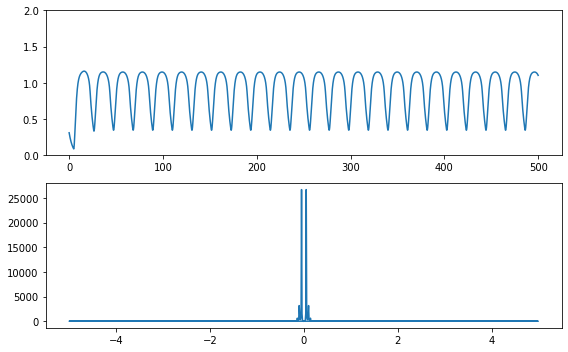

In [132]:

pws = myclock.pws()
dominant_period = myclock.estimate_period_fft()
plt.clf()
fig = plt.figure('timelapse', figsize=(8, 5), tight_layout=True)
ax = fig.add_subplot(211)
ax.plot(tvector,timelapse[:,myclock.index_choice])#[int(tmax/2):tmax]
plt.ylim(0,2)
ax2 = fig.add_subplot(212)
ax2.plot(np.fft.fftfreq(len(pws), dt), pws[:,myclock.index_choice])
#plt.xlim(-10/dominant_period, 10/dominant_period)
#plt.axvline(-1/dominant_period)
#plt.axvline(1/dominant_period)
plt.show()
fig.savefig("timelapse_and_pws.pdf")

<b> Bifurcation figure for two parameters </b>


In [133]:

#t= np.arange(0,100,.1,dtype=float)
xs_int = np.array([2.23,0.83,0.31,0.48,0.037],dtype=float) 

Npoints=10
oscillationKs = []
oscillationVd = []
nooscillationKs = []
nooscillationVd = []
for Ks in np.linspace(1,160,Npoints):
    for Vd in np.linspace(0.0002,0.18,Npoints):   
    
        parms['Ks'] = Ks
        parms['Vd'] = Vd
        myclock= monomer_clock();
        # then everything about a given model in encoded into a "class" - see file clock_models.py

        myclock.setparameters(parms)
        xs= myclock.timelapse()
        #plt.plot(xs[:,0])
        if abs(np.min(xs[3000:,0])-np.max(xs[3000:,0]))<10**(-10):#np.any(np.real(abs(xs[800,0]-xs[700,0]))< 0.1) : #rem: the condition for oscillation is a bit rough here...

            nooscillationKs.append(Ks)
            nooscillationVd.append(Vd)
       
        else:
            period_est = myclock.estimate_period()
            if math.isnan(period_est):
                nooscillationKs.append(Ks)
                nooscillationVd.append(Vd)
            else:
                #print(period_est)
                #period_est_fft=myclock.estimate_period_fft()
                #print(period_est_fft)
                oscillationKs.append(Ks)
                oscillationVd.append(Vd)

16.666666666666668
25.0


/Users/sdebuyl/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/sdebuyl/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


12.5
16.666666666666668
20.0
11.11111111111111
12.5
16.666666666666668
11.11111111111111
12.5
14.285714285714285
11.11111111111111
14.285714285714285
12.5
11.11111111111111
14.285714285714285
12.5
12.5
14.285714285714285


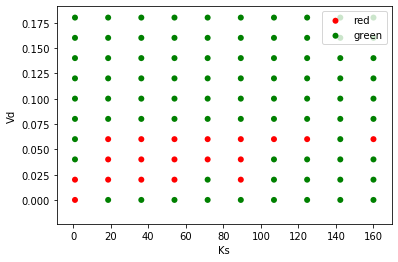

In [134]:
#plt.rcParams['legend.numpoints'] = 1

fig, ax = plt.subplots()
for color in ['red', 'green']:
    if (color=='red'):
        x, y = [oscillationKs,oscillationVd]
        ax.scatter(x, y, c=color, label='red',edgecolors='none')
    if (color=='green'):
        x, y = [nooscillationKs,nooscillationVd]
        ax.scatter(x, y, c=color, label=color,edgecolors='none')

ax.legend(scatterpoints=1,loc='upper right')
#ax.grid(True)
plt.xlabel('Ks')
plt.ylabel('Vd')
plt.show()

The red region is the region in parameter space leading to oscillations. Rem: a finer resolution would be nicer! (but as it is the code is very fast)

<b> Bifurcation diagram for one parameter </b>

Let us fix $K_s$ and vary $V_d$. We will now represent on the y-axis the position of the fixed point or the min and max values of the oscillations of one of the dynamical variables. When the system goes to a fixed point, the min and max values are simply equal to each other. 

In [81]:
diagram_under_construction = False  #to estimate the period and plot time traces to check the bifurcation diagram obtained makes sense

#t= np.arange(0,100,.1,dtype=float)
xs_int = np.array([2.23,0.83,0.31,0.48,0.037],dtype=float) 
Npoints=100
parms['Vd']=0.022 #we varied that parameter to make the previous figure, here we reset the default value
list_para= np.linspace(0,80,Npoints)
min_list = np.zeros(len(list_para))
max_list = np.zeros(len(list_para))
for kk in range(len(list_para)):   
    parms['Ks'] = list_para[kk]
    myclock= monomer_clock();
    
    # then everything about a given model in encoded into a "class" - see file clock_models.py
    myclock.setparameters(parms)
    xs= myclock.timelapse()
    if diagram_under_construction == True:
        print('estimation of the period two ways ',myclock.estimate_period(),' and ',myclock.estimate_period_fft())
        plt.plot(xs[:,0])
    min_list[kk] = np.min(xs[3000:,0])  #we remove the transcient period and look at min and max
    max_list [kk]= np.max(xs[3000:,0])

Text(0.5, 0, '$K_s$')

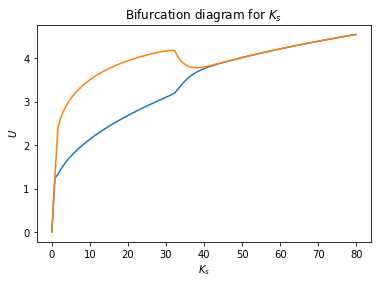

In [82]:
plt.title('Bifurcation diagram for $K_s$')
plt.plot(list_para,min_list)
plt.plot(list_para,max_list)
plt.ylabel('$U$')
plt.xlabel('$K_s$')